In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

# Directory path for the dataset
dataset_path = "/kaggle/input/ucmerced-landuse/UCMerced_LandUse/Images"

# List of class labels
categories = os.listdir(dataset_path)

# Initialize data and labels lists
data = []
labels = []

# Load images and labels
for label, category in enumerate(categories):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        img_path = os.path.join(category_path, image_name)
        
        # Load and preprocess image
        img = cv2.imread(img_path)
        img = cv2.resize(img, (224, 224))  # Resize to 224x224 for VGG16/ResNet
        img = img.astype('float32') / 255.0  # Normalize to 0-1
        
        data.append(img)
        labels.append(label)

# Convert lists to numpy arrays
data = np.array(data)
labels = np.array(labels)



In [2]:
# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels)

In [3]:
# Check the length of the training and testing datasets
print("Length of training dataset:", len(X_train))
print("Length of testing dataset:", len(X_test))
# Check the shape of one image (should be 224x224x3 for a colored image)
print("Shape of one image:", X_train[0].shape)


Length of training dataset: 1680
Length of testing dataset: 420
Shape of one image: (224, 224, 3)


# 1. Deep Feature Extraction with VGG16


In [4]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model

# Load the VGG16 model, excluding the final classification layers
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Create a new model that outputs the features from the last convolutional layer
vgg_feature_extractor = Model(inputs=vgg_model.input, outputs=vgg_model.output)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [6]:
# Extract features for all images in the training and testing datasets using VGG16
train_features_vgg = vgg_feature_extractor.predict(X_train)
test_features_vgg = vgg_feature_extractor.predict(X_test)

# Flatten the features to make them compatible for classification (1D array per image)
train_features_vgg = train_features_vgg.reshape(train_features_vgg.shape[0], -1)
test_features_vgg = test_features_vgg.reshape(test_features_vgg.shape[0], -1)

print("VGG16 feature shape (train):", train_features_vgg.shape)
print("VGG16 feature shape (test):", test_features_vgg.shape)


53/53 ━━━━━━━━━━━━━━━━━━━━ 418s 8s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 103s 7s/step
VGG16 feature shape (train): (1680, 25088)
VGG16 feature shape (test): (420, 25088)


In [7]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Normalisation des caractéristiques extraites
scaler = StandardScaler()

# Apprendre la moyenne et l'écart type sur l'ensemble d'entraînement, puis transformer les deux ensembles (train et test)
train_features_vgg_scaled = scaler.fit_transform(train_features_vgg)
test_features_vgg_scaled = scaler.transform(test_features_vgg)



In [8]:
# 2. Entraînement du classificateur SVM
svm_classifier = SVC(kernel='linear')  
svm_classifier.fit(train_features_vgg_scaled, y_train)


SVC(kernel='linear')

In [9]:
# 3. Prédiction sur l'ensemble de test
y_pred_vgg = svm_classifier.predict(test_features_vgg_scaled)

In [10]:
# 4. Calcul de l'exactitude (accuracy)
accuracy = accuracy_score(y_test, y_pred_vgg)
print(f"Accuracy of SVM classifier using VGG16 features: {accuracy:.4f}")

Accuracy of SVM classifier using VGG16 features: 0.8976


In [11]:
# 5. Génération de la matrice de confusion
cm = confusion_matrix(y_test, y_pred_vgg)


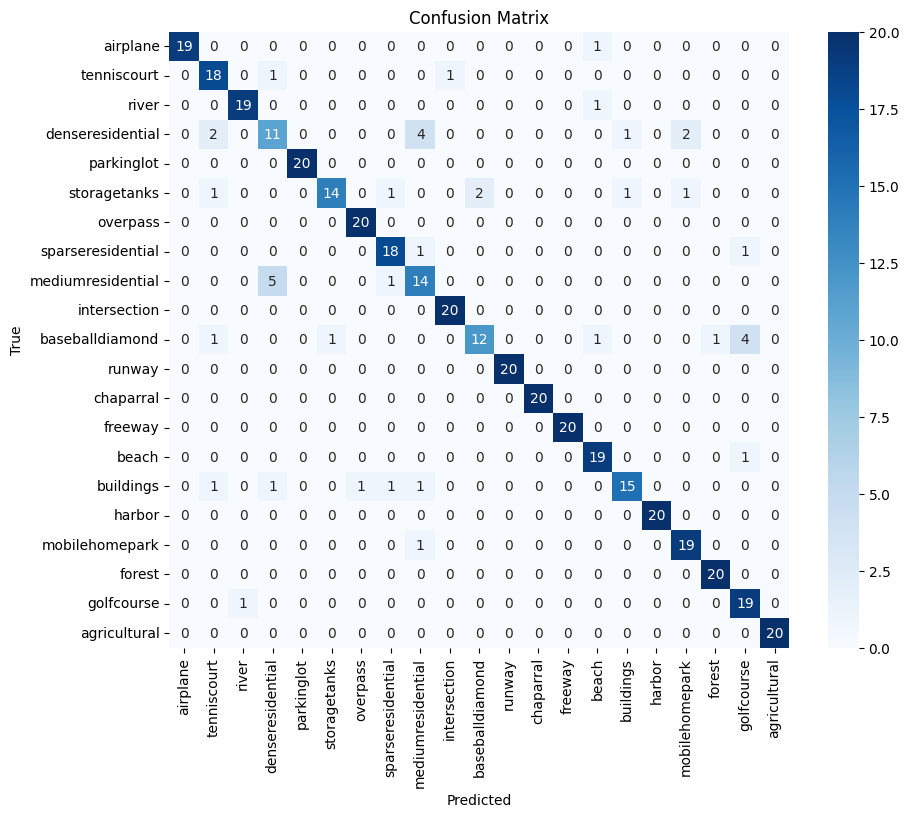

In [12]:
# Affichage de la matrice de confusion avec Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


 # 2. Deep Feature Extraction with ResNet50


In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model

# Charger le modèle ResNet50, en excluant la couche de classification finale
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))



94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [16]:
# Créer un nouveau modèle qui renvoie les caractéristiques de la dernière couche convolutive
resnet_feature_extractor = Model(inputs=resnet_model.input, outputs=resnet_model.output)

In [17]:
# Extraire les caractéristiques pour toutes les images dans les ensembles d'entraînement et de test avec ResNet50
train_features_resnet = resnet_feature_extractor.predict(X_train)
test_features_resnet = resnet_feature_extractor.predict(X_test)

53/53 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step


In [18]:
# Aplatir les caractéristiques extraites pour les rendre compatibles avec la classification (tableau 1D par image)
train_features_resnet = train_features_resnet.reshape(train_features_resnet.shape[0], -1)
test_features_resnet = test_features_resnet.reshape(test_features_resnet.shape[0], -1)

print("ResNet50 feature shape (train):", train_features_resnet.shape)
print("ResNet50 feature shape (test):", test_features_resnet.shape)

ResNet50 feature shape (train): (1680, 100352)
ResNet50 feature shape (test): (420, 100352)


In [19]:
# Normalisation des caractéristiques extraites
train_features_resnet_scaled = scaler.fit_transform(train_features_resnet)
test_features_resnet_scaled = scaler.transform(test_features_resnet)


In [20]:
# Entraînement du classificateur SVM avec les caractéristiques de ResNet50
svm_classifier_resnet = SVC(kernel='linear')
svm_classifier_resnet.fit(train_features_resnet_scaled, y_train)

SVC(kernel='linear')

In [21]:
# Prédiction sur l'ensemble de test avec les caractéristiques de ResNet50
y_pred_resnet = svm_classifier_resnet.predict(test_features_resnet_scaled)

In [22]:
# Calcul de l'exactitude (accuracy) avec ResNet50
accuracy_resnet = accuracy_score(y_test, y_pred_resnet)
print(f"Accuracy of SVM classifier using ResNet50 features: {accuracy_resnet:.4f}")

Accuracy of SVM classifier using ResNet50 features: 0.6429


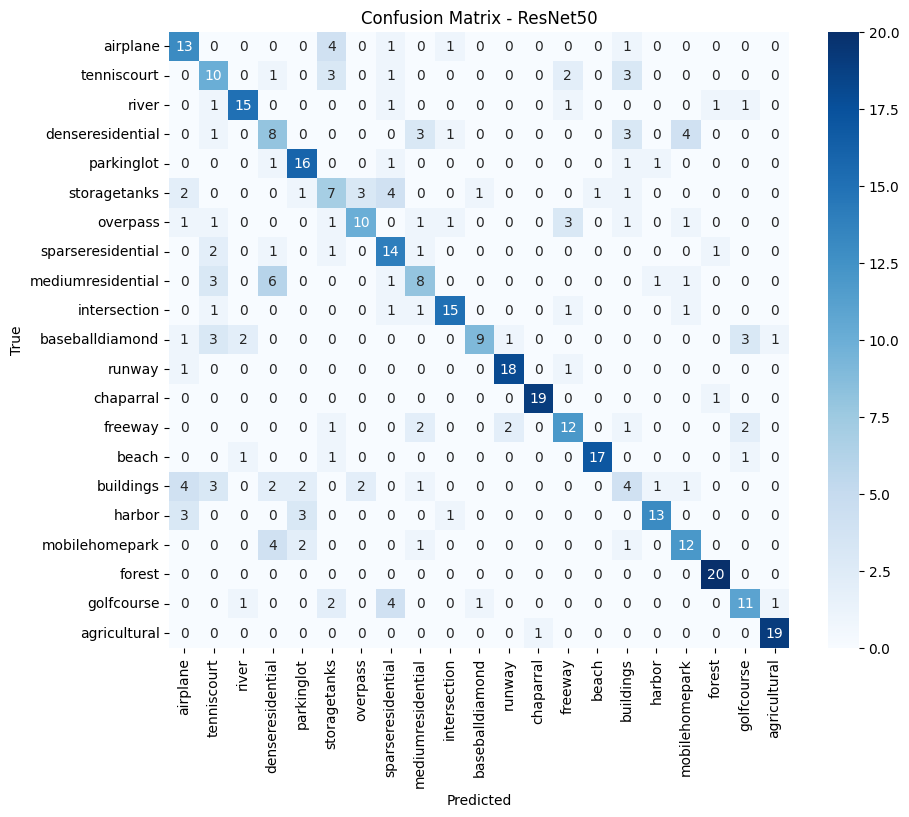

In [23]:
# Génération de la matrice de confusion pour ResNet50
cm_resnet = confusion_matrix(y_test, y_pred_resnet)

# Affichage de la matrice de confusion avec Seaborn pour ResNet50
plt.figure(figsize=(10, 8))
sns.heatmap(cm_resnet, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.show()

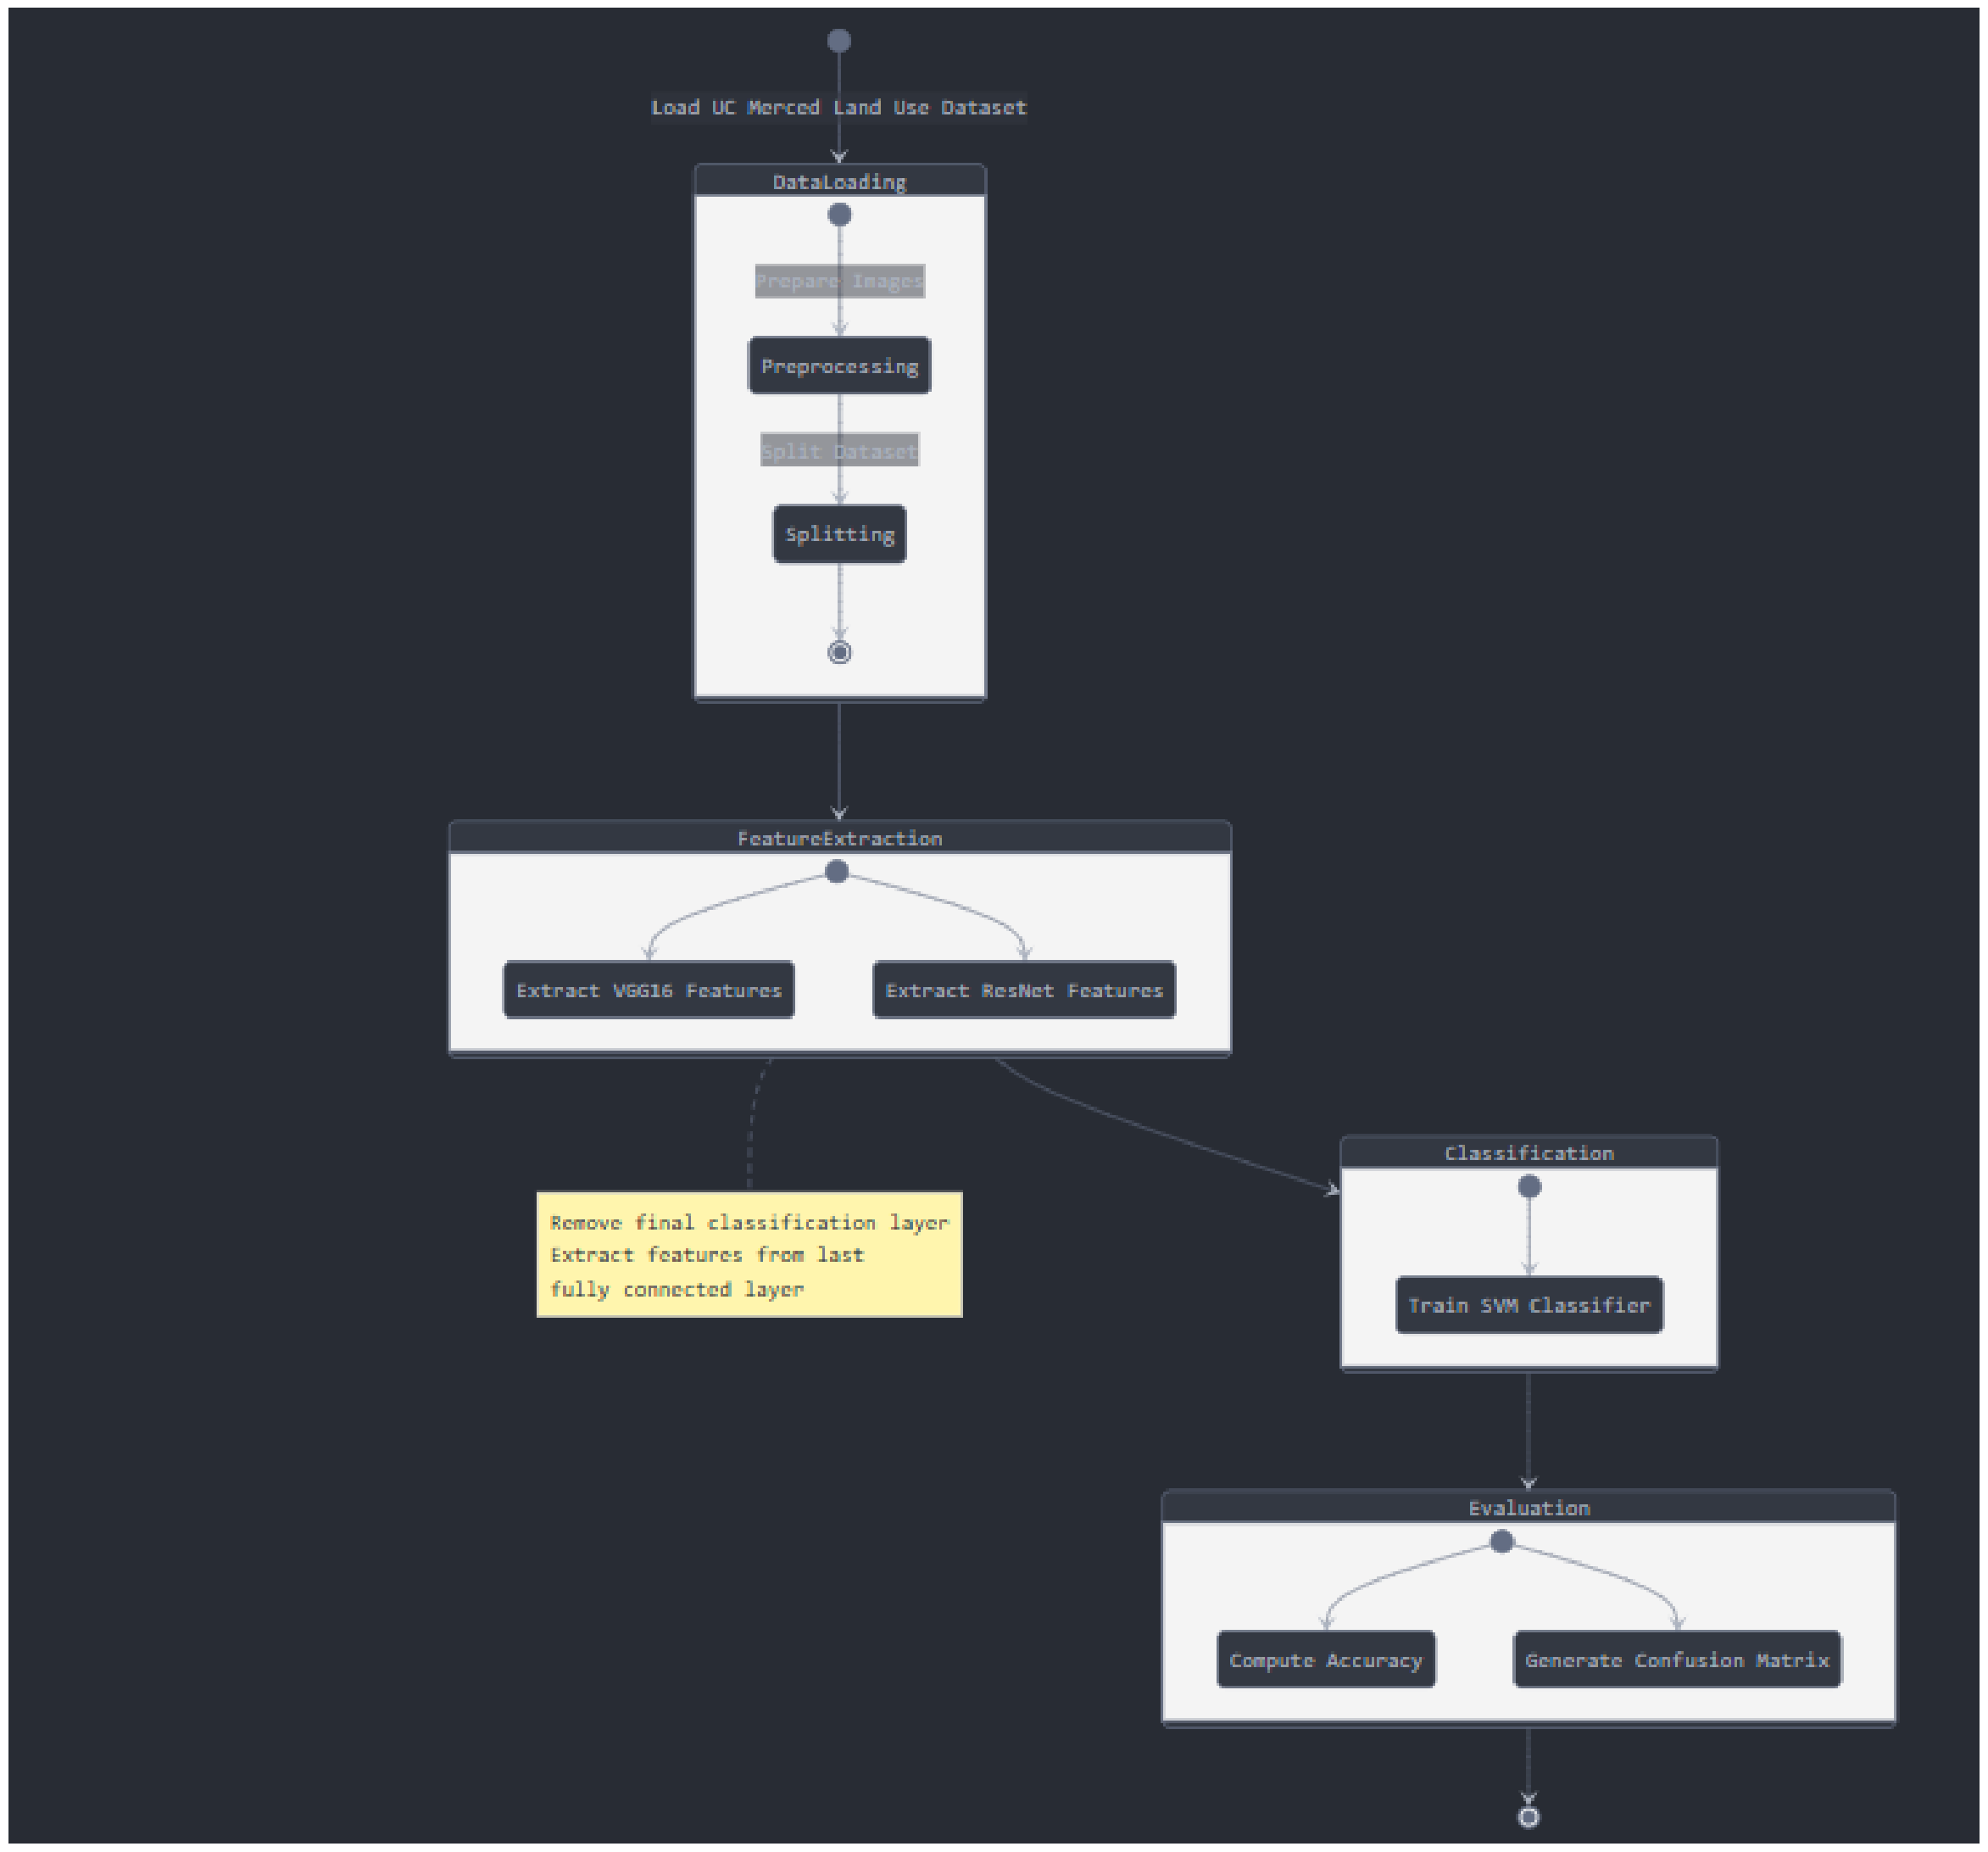

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('/kaggle/input/diagramme/Screenshot 2024-11-19 155117.png')
plt.figure(figsize=(30, 30)) 
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()